In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2026-01-14 18:39:11.238531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-14 18:39:11.281568: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-14 18:39:12.403076: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/rooneyish/Applied_Machine_Learning/News_Article_Classification/.venv/lib/python3.11/s

Num GPUs Available:  0


2026-01-14 18:39:13.330279: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-14 18:39:13.330306: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2026-01-14 18:39:13.330310: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-01-14 18:39:13.330313: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-01-14 18:39:13.330316: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: rooneyish
2026-01-14 18:39:13.330317: I external/local_xla/xla/stream_executor/cuda/cud

In [2]:
import pandas as pd

In [3]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
val = pd.read_csv('val_data.csv')

In [4]:
train.sample(5)

,X,y
34361,despite peace deals sudan 39s darfur region is...,1
19201,scientists say changes in the earth 39s climat...,4
20627,new york reuters yous stocks ended lower on tu...,3
88283,ap a bus truck and taxi collided in a mountain...,1
44624,congressional lawmakers are taking a cue from ...,4


In [5]:
test.sample(5)

,X,y
5067,boudewijn zenden scored twice as middlesbrough...,2
364,ap south korean nuclear experiments revealed e...,1
15372,ap the cleveland browns offense was pretty awf...,2
6826,the head of interactivecorp talks about the co...,4
7171,the space shuttle should be used to service th...,4


In [6]:
val.sample(5)

,X,y
13425,the first african woman to win the nobel peace...,1
9771,reuters an explosion at a southwest houstonche...,3
17655,on the same day that tiger woods was married i...,2
1357,robert mugabes government is pushing through l...,2
18444,ap you would think the details would be scorch...,1


In [7]:
train.shape, test.shape, val.shape

((89320, 2), (19140, 2), (19140, 2))

In [8]:
train['y'] = train['y'] - 1
val['y'] = val['y'] - 1
test['y'] = test['y'] - 1

In [9]:
import numpy as np

In [10]:
glove_path = 'glove.6B.100d.txt'

def load_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_embeddings(glove_path)

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
max_words = 20000
max_len = 100

In [13]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['X'])

X_train_seq = tokenizer.texts_to_sequences(train['X'])
X_val_seq = tokenizer.texts_to_sequences(val['X'])
X_test_seq = tokenizer.texts_to_sequences(test['X'])

X_train = pad_sequences(X_train_seq, maxlen=max_len)
X_val = pad_sequences(X_val_seq, maxlen=max_len)
X_test = pad_sequences(X_test_seq, maxlen=max_len)

In [14]:
X_train[:1]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   817,    19,   891,     3,  8380,     2,   473,     3,
        14986,     1,  2913,     4,    36,   179,   883,  1802, 16016,
            6,  1319,     1,   802,  1087,  7590,  7765,     6,  3668,
         5888]], dtype=int32)

In [15]:
embedding_dim = 100
word_index = tokenizer.word_index
word_index

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 'for': 8,
 'that': 9,
 '39s': 10,
 'with': 11,
 'as': 12,
 'is': 13,
 'its': 14,
 'at': 15,
 'said': 16,
 'it': 17,
 'by': 18,
 'has': 19,
 'new': 20,
 'an': 21,
 'from': 22,
 'his': 23,
 'will': 24,
 'was': 25,
 'reuters': 26,
 'after': 27,
 'have': 28,
 'be': 29,
 'their': 30,
 'are': 31,
 'over': 32,
 'he': 33,
 'us': 34,
 'ap': 35,
 'two': 36,
 'but': 37,
 'first': 38,
 'this': 39,
 'more': 40,
 'monday': 41,
 'not': 42,
 'tuesday': 43,
 'wednesday': 44,
 'thursday': 45,
 'company': 46,
 'up': 47,
 'inc': 48,
 'friday': 49,
 'one': 50,
 'they': 51,
 'world': 52,
 'yesterday': 53,
 'last': 54,
 'york': 55,
 'against': 56,
 'who': 57,
 'than': 58,
 'were': 59,
 'about': 60,
 'into': 61,
 'year': 62,
 'been': 63,
 'president': 64,
 'out': 65,
 'yous': 66,
 'had': 67,
 'when': 68,
 'would': 69,
 'million': 70,
 'corp': 71,
 'oil': 72,
 'united': 73,
 'week': 74,
 'sunday': 75,
 'years': 76,
 'which': 77,
 'people':

In [16]:
len(word_index)

80474

In [17]:
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

num_classes = 4

model = Sequential([       
    Input(shape=(num_words,)),
    Embedding(num_words, 
              embedding_dim, 
              weights=[embedding_matrix], 
              trainable=False), 
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax') 
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20000, 100)     │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,088,740 (7.97 MB)

 Trainable params: 88,740 (346.64 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [19]:
history = model.fit(
    X_train, train['y'],
    epochs=10,
    batch_size=64,
    validation_data=(X_val, val['y']),
    verbose=1,
)

Epoch 1/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 66s 46ms/step - accuracy: 0.8647 - loss: 0.3861 - val_accuracy: 0.8938 - val_loss: 0.3026
Epoch 2/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 62s 44ms/step - accuracy: 0.8940 - loss: 0.3055 - val_accuracy: 0.8970 - val_loss: 0.2871
Epoch 3/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.9021 - loss: 0.2804 - val_accuracy: 0.9046 - val_loss: 0.2685
Epoch 4/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9075 - loss: 0.2631 - val_accuracy: 0.9071 - val_loss: 0.2611
Epoch 5/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9136 - loss: 0.2471 - val_accuracy: 0.9117 - val_loss: 0.2560
Epoch 6/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9182 - loss: 0.2333 - val_accuracy: 0.9068 - val_loss: 0.2676
Epoch 7/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9219 - loss: 0.2201 - val_accuracy: 0.9091 - val_loss: 0.2517
Epoch 8/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - accuracy: 0.9255 -

In [20]:
test_loss, test_accuracy = model.evaluate(X_test, test['y'], verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9155 - loss: 0.2520
Test Loss: 0.2520
Test Accuracy: 0.9155


In [21]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

2792/2792 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


In [22]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

train_accuracy = accuracy_score(train['y'], np.argmax(y_train_pred, axis = 1))
train_f1_score = f1_score(train['y'], np.argmax(y_train_pred, axis = 1), average='weighted')
val_accuracy = accuracy_score(val['y'], np.argmax(y_val_pred, axis = 1))
val_f1_score = f1_score(val['y'], np.argmax(y_val_pred, axis = 1), average='weighted')
test_accuracy = accuracy_score(test['y'], np.argmax(y_test_pred, axis = 1))
test_f1_score = f1_score(test['y'], np.argmax(y_test_pred, axis = 1), average='weighted')

print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}% \n")
print(f"Train F1 Score: {train_f1_score:.2f}")
print(f"Validation F1 Score: {val_f1_score:.2f}")
print(f"Test F1 Score: {test_f1_score:.2f} \n")

class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

print(classification_report(test['y'],np.argmax(y_test_pred, axis = 1), target_names=class_names, digits=4))

Train Accuracy: 94.13%
Validation Accuracy: 91.20%
Test Accuracy: 91.55% 

Train F1 Score: 0.94
Validation F1 Score: 0.91
Test F1 Score: 0.92 

              precision    recall  f1-score   support

       World     0.9463    0.9053    0.9253      4785
      Sports     0.9537    0.9822    0.9678      4785
    Business     0.9100    0.8518    0.8800      4785
    Sci/Tech     0.8563    0.9225    0.8881      4785

    accuracy                         0.9155     19140
   macro avg     0.9166    0.9155    0.9153     19140
weighted avg     0.9166    0.9155    0.9153     19140



In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [24]:
cm = confusion_matrix(test['y'], np.argmax(y_test_pred, axis=1))
cm

array([[4332,  116,  151,  186],
       [  34, 4700,   28,   23],
       [ 122,   55, 4076,  532],
       [  90,   57,  224, 4414]])

<Axes: >

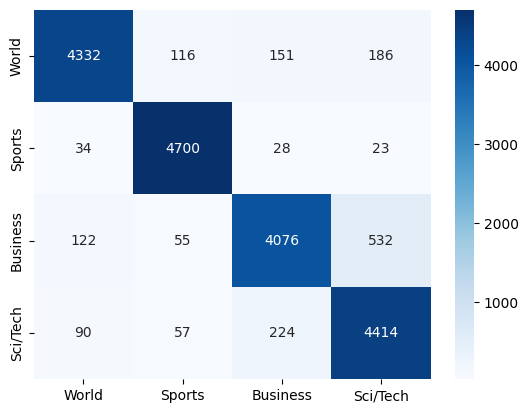

In [25]:
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names )